In [2]:
import numpy as np 
import matplotlib.pyplot as plt
import pandas as pd 
import mplhep as hep 
import uproot
from scipy.stats import bootstrap
from scipy.special import factorial
from scipy.optimize import curve_fit
plt.style.use(hep.style.CMS)

# Resolutions

In [1]:
import uproot
import pandas as pd
import numpy as np
from pathlib import Path

# Directory containing the ROOT files
input_dir = Path('LSO_WithReal')

# Output ROOT file
output_file = 'combined.root'

# List of energies
energies = list(range(100, 900, 100))

# Initialize lists to hold concatenated DataFrames
edep_dfs = []
sipm_dfs = []

# Variable to keep track of the EventID offset
event_offset = 0

for energy in energies:
    file_path = input_dir / f'Energy_{energy}.root'
    
    if not file_path.exists():
        print(f"File {file_path} not found, skipping.")
        continue
    
    # Open the ROOT file
    with uproot.open(file_path) as root_file:
        # Access the trees
        edep_tree = root_file['EdepCounter']
        sipm_tree = root_file['SiPM']
        
        # Read the branches into pandas DataFrames
        edep_df = edep_tree.arrays(['EventID', 'Edep_MeV'], library='pd')
        sipm_df = sipm_tree.arrays(['EventID', '#PE', '#NoisePE'], library='pd')
        
        # Add offset to EventID to avoid duplicates
        edep_df['EventID'] += event_offset
        sipm_df['EventID'] += event_offset
        
        # Add Energy column
        edep_df['Energy_keV'] = energy
        sipm_df['Energy_keV'] = energy
        
        # Append to lists
        edep_dfs.append(edep_df)
        sipm_dfs.append(sipm_df)
        
        # Update offset for next file
        max_event = max(edep_df['EventID'].max(), sipm_df['EventID'].max())
        event_offset = max_event + 1

# Concatenate all DataFrames
combined_edep_df = pd.concat(edep_dfs, ignore_index=True)
combined_sipm_df = pd.concat(sipm_dfs, ignore_index=True)

# Optional: Merge for verification
merged_df = pd.merge(combined_edep_df, combined_sipm_df, on=['EventID', 'Energy_keV'])
print(f"Total events: {len(merged_df)}")
print(merged_df.head())

# Write to new ROOT file
with uproot.recreate(output_file) as out_file:
    # Write EdepCounter tree
    out_file['EdepCounter'] = {
        'EventID': combined_edep_df['EventID'].to_numpy(),
        'Edep_MeV': combined_edep_df['Edep_MeV'].to_numpy(),
        'Energy_keV': combined_edep_df['Energy_keV'].to_numpy()
    }
    
    # Write SiPM tree
    out_file['SiPM'] = {
        'EventID': combined_sipm_df['EventID'].to_numpy(),
        '#PE': combined_sipm_df['#PE'].to_numpy(),
        '#NoisePE': combined_sipm_df['#NoisePE'].to_numpy(),
        'Energy_keV': combined_sipm_df['Energy_keV'].to_numpy()
    }

print(f"Combined data saved to '{output_file}'")

Total events: 277793
   EventID  Edep_MeV  Energy_keV  #PE  #NoisePE
0      350  0.041760         100   22         3
1      351  0.107834         100   82        23
2      352  0.107458         100   63        21
3      353  0.107613         100   71        17
4      354  0.107614         100   56        13
Combined data saved to 'combined.root'


In [30]:
import uproot
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
from pathlib import Path

# Path to the combined ROOT file
file_path = 'combined.root'

# Open the ROOT file
root_file = uproot.open(file_path)

# Access the trees
edep_tree = root_file['EdepCounter']
sipm_tree = root_file['SiPM']

# Read the branches into pandas DataFrames
edep_df = edep_tree.arrays(['EventID', 'Edep_MeV', 'Energy_keV'], library='pd')
sipm_df = sipm_tree.arrays(['EventID', '#PE', '#NoisePE', 'Energy_keV'], library='pd')

# Merge the DataFrames on EventID and Energy_keV
merged_df = pd.merge(edep_df, sipm_df, on=['EventID', 'Energy_keV'])

# Compute SignalPE
merged_df['SignalPE'] = merged_df['#PE'] - merged_df['#NoisePE']

# Group by Energy_keV
grouped = merged_df.groupby('Energy_keV')

# Create a directory for output datasets
output_dir = Path('classified_datasets')
output_dir.mkdir(exist_ok=True)

# Function to fit Gaussian to counts (bin width=1)
def gaussian_counts(x, N, mean, std):
    return N * np.exp(-((x - mean)**2) / (2 * std**2)) / (std * np.sqrt(2 * np.pi))

# Dictionary to store resolutions
resolutions = {}

for energy, group in grouped:
    # Save the subgroup to CSV
    group.to_csv(output_dir / f'dataset_{energy}_keV.csv', index=False)
    print(f"Saved dataset for {energy} keV to {output_dir / f'dataset_{energy}_keV.csv'}")
    
    # Histogram the SignalPE with integer bins, density=False for counts
    min_pe = int(group['SignalPE'].min())
    max_pe = int(group['SignalPE'].max())
    bins = np.arange(min_pe - 0.5, max_pe + 1.5, 1)
    hist, bin_edges = np.histogram(group['SignalPE'], bins=bins, density=False)
    bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2
    
    # Mask for non-zero hist entries to focus on data
    mask = hist > 0
    bin_centers_masked = bin_centers[mask]
    hist_masked = hist[mask]
    
    # Initial guess
    N_init = len(group)
    mean_init = group['SignalPE'].mean()
    std_init = group['SignalPE'].std()
    if std_init == 0:
        std_init = 1.0
    initial_guess = [N_init, mean_init, std_init]
    
    # Plot setup
    plt.figure(figsize=(10, 6))
    plt.hist(group['SignalPE'], bins=bins, alpha=0.6, label='Data')
    
    fitted = False
    try:
        # Bounds: N >0, mean in range, std >0
        lower_bounds = [0, mean_init - 5*std_init, 0.1]
        upper_bounds = [np.inf, mean_init + 5*std_init, np.inf]
        popt, pcov = curve_fit(gaussian_counts, bin_centers_masked, hist_masked, p0=initial_guess, bounds=(lower_bounds, upper_bounds), method='trf', maxfev=20000)
        fitted_N = popt[0]
        fitted_mean = popt[1]
        fitted_std = abs(popt[2])
        fwhm = 2.355 * fitted_std
        resolution = (fwhm / fitted_mean) * 100 if fitted_mean != 0 else 0
        resolutions[energy] = resolution
        
        # Plot fit
        x = np.linspace(bin_centers.min(), bin_centers.max(), 1000)
        plt.plot(x, gaussian_counts(x, *popt), 'r-', label='Gaussian Fit')
        print(f"Resolution for {energy} keV: {resolution:.2f}%")
        fitted = True
    except Exception as e:
        print(f"Fit failed for {energy} keV: {e}")
        # Fallback to simple stats
        mean_pe = group['SignalPE'].mean()
        std_pe = group['SignalPE'].std()
        resolution = (2.355 * std_pe / mean_pe) * 100 if mean_pe != 0 else 0
        resolutions[energy] = resolution
        print(f"Fallback resolution for {energy} keV: {resolution:.2f}%")
    
    # Always save the plot
    plt.xlabel('SignalPE')
    plt.ylabel('Counts')
    plt.title(f'SignalPE Distribution for {energy} keV')
    plt.legend()
    plt.grid(True)
    plt.savefig(output_dir / f'hist_{energy}_keV.png')
    plt.close()

# Save resolutions to a file
res_df = pd.DataFrame(list(resolutions.items()), columns=['Energy_keV', 'Resolution_%'])
res_df.to_csv(output_dir / 'resolutions.csv', index=False)
print("Resolutions saved to 'classified_datasets/resolutions.csv'")

Saved dataset for 100 keV to classified_datasets/dataset_100_keV.csv
Resolution for 100 keV: 34.99%
Saved dataset for 200 keV to classified_datasets/dataset_200_keV.csv
Resolution for 200 keV: 24.84%
Saved dataset for 300 keV to classified_datasets/dataset_300_keV.csv
Resolution for 300 keV: 20.13%
Saved dataset for 400 keV to classified_datasets/dataset_400_keV.csv
Resolution for 400 keV: 17.67%
Saved dataset for 500 keV to classified_datasets/dataset_500_keV.csv
Resolution for 500 keV: 15.48%
Saved dataset for 600 keV to classified_datasets/dataset_600_keV.csv
Resolution for 600 keV: 14.08%
Saved dataset for 700 keV to classified_datasets/dataset_700_keV.csv
Resolution for 700 keV: 134.29%
Saved dataset for 800 keV to classified_datasets/dataset_800_keV.csv
Resolution for 800 keV: 132.68%
Resolutions saved to 'classified_datasets/resolutions.csv'


In [21]:
import uproot
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
from pathlib import Path

# Path to the combined ROOT file
file_path = 'combined.root'

# Open the ROOT file
root_file = uproot.open(file_path)

# Access the trees
edep_tree = root_file['EdepCounter']
sipm_tree = root_file['SiPM']

# Read the branches into pandas DataFrames (ignoring Energy_keV since not interested)
edep_df = edep_tree.arrays(['EventID', 'Edep_MeV'], library='pd')
sipm_df = sipm_tree.arrays(['EventID', '#PE', '#NoisePE'], library='pd')

# Merge the DataFrames on EventID
merged_df = pd.merge(edep_df, sipm_df, on='EventID')

# Compute SignalPE
merged_df['SignalPE'] = merged_df['#PE'] - merged_df['#NoisePE']

# Sort by Edep_MeV
merged_df = merged_df.sort_values('Edep_MeV')

# Define fine bin width (e.g., 0.001 MeV = 1 keV)
bin_width = 0.001
min_edep = merged_df['Edep_MeV'].min()
max_edep = merged_df['Edep_MeV'].max()
bin_edges = np.arange(min_edep, max_edep + bin_width, bin_width)

# Assign fine bins
merged_df['fine_bin'] = pd.cut(merged_df['Edep_MeV'], bins=bin_edges, labels=False, include_lowest=True)

# Get counts per fine bin
bin_counts = merged_df['fine_bin'].value_counts().sort_index()

# Merge small bins: accumulate consecutive bins until >= min_events
min_events = 2000
merged_groups = []
current_group = []
current_count = 0
group_id = 0

for bin_idx, count in bin_counts.items():
    current_group.append(bin_idx)
    current_count += count
    if current_count >= min_events:
        # Assign group_id to these fine bins
        merged_df.loc[merged_df['fine_bin'].isin(current_group), 'merged_bin'] = group_id
        # Record the bin range
        low_edge = bin_edges[min(current_group)]
        high_edge = bin_edges[max(current_group) + 1]
        merged_groups.append((group_id, low_edge, high_edge, current_count))
        # Reset
        group_id += 1
        current_group = []
        current_count = 0

# If there's a remaining small group, merge it to the previous if exists, else keep
if current_group:
    if merged_groups:
        # Merge to last group
        last_group_id, last_low, last_high, last_count = merged_groups[-1]
        merged_df.loc[merged_df['fine_bin'].isin(current_group), 'merged_bin'] = last_group_id
        new_high = bin_edges[max(current_group) + 1]
        merged_groups[-1] = (last_group_id, last_low, new_high, last_count + current_count)
    else:
        # If no previous, keep as is
        low_edge = bin_edges[min(current_group)]
        high_edge = bin_edges[max(current_group) + 1]
        merged_df.loc[merged_df['fine_bin'].isin(current_group), 'merged_bin'] = group_id
        merged_groups.append((group_id, low_edge, high_edge, current_count))

# Ensure merged_bin is integer
merged_df['merged_bin'] = merged_df['merged_bin'].astype(int)

# Group by merged_bin
grouped = merged_df.groupby('merged_bin')

# Create a directory for output datasets
output_dir = Path('classified_datasets_edep')
output_dir.mkdir(exist_ok=True)

# Function to fit Gaussian
def gaussian(x, amp, mean, std):
    return amp * np.exp(-((x - mean)**2) / (2 * std**2))

# Dictionary to store resolutions
resolutions = {}

for bin_id, group in grouped:
    # Get bin range
    for g_id, low, high, cnt in merged_groups:
        if g_id == bin_id:
            bin_label = f'{low:.3f}_to_{high:.3f}_MeV'
            break
    
    # Save the subgroup to CSV
    group.to_csv(output_dir / f'dataset_{bin_label}.csv', index=False)
    print(f"Saved dataset for {bin_label} (events: {len(group)}) to {output_dir / f'dataset_{bin_label}.csv'}")
    
    # For energy resolution using SignalPE
    # Histogram the SignalPE with integer bins
    min_pe = int(group['SignalPE'].min())
    max_pe = int(group['SignalPE'].max())
    bins = np.arange(min_pe - 0.5, max_pe + 1.5, 1)
    hist, bin_edges = np.histogram(group['SignalPE'], bins=bins, density=True)
    bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2
    
    # Initial guess for fit
    amp = hist.max()
    mean = group['SignalPE'].mean()
    std = group['SignalPE'].std()
    initial_guess = [amp, mean, std]
    
    # Fit Gaussian
    try:
        popt, pcov = curve_fit(gaussian, bin_centers, hist, p0=initial_guess)
        fitted_mean = popt[1]
        fitted_std = abs(popt[2])
        fwhm = 2.355 * fitted_std
        resolution = (fwhm / fitted_mean) * 100 if fitted_mean != 0 else 0
        resolutions[bin_label] = resolution
        
        # Plot histogram and fit
        plt.figure(figsize=(10, 6))
        plt.hist(group['SignalPE'], bins=bins, density=True, alpha=0.6, label='Data')
        x = np.linspace(bin_centers.min(), bin_centers.max(), 1000)
        plt.plot(x, gaussian(x, *popt), 'r-', label='Gaussian Fit')
        plt.xlabel('SignalPE')
        plt.ylabel('Density')
        plt.title(f'SignalPE Distribution for Edep {bin_label}')
        plt.legend()
        plt.grid(True)
        plt.savefig(output_dir / f'hist_{bin_label}.png')
        plt.close()
        
        print(f"Resolution for {bin_label}: {resolution:.2f}%")
    except Exception as e:
        print(f"Fit failed for {bin_label}: {e}")
        # Fallback to simple stats
        mean_pe = group['SignalPE'].mean()
        std_pe = group['SignalPE'].std()
        resolution = (2.355 * std_pe / mean_pe) * 100 if mean_pe != 0 else 0
        resolutions[bin_label] = resolution
        print(f"Fallback resolution for {bin_label}: {resolution:.2f}%")

# Save resolutions to a file
res_df = pd.DataFrame(list(resolutions.items()), columns=['Edep_Range', 'Resolution_%'])
res_df.to_csv(output_dir / 'resolutions.csv', index=False)
print("Resolutions saved to 'classified_datasets_edep/resolutions.csv'")

Saved dataset for 0.000_to_0.012_MeV (events: 2197) to classified_datasets_edep/dataset_0.000_to_0.012_MeV.csv
Resolution for 0.000_to_0.012_MeV: 203.41%
Saved dataset for 0.012_to_0.022_MeV (events: 2007) to classified_datasets_edep/dataset_0.012_to_0.022_MeV.csv
Resolution for 0.012_to_0.022_MeV: 96.85%
Saved dataset for 0.022_to_0.032_MeV (events: 2027) to classified_datasets_edep/dataset_0.022_to_0.032_MeV.csv
Resolution for 0.022_to_0.032_MeV: 74.11%
Saved dataset for 0.032_to_0.042_MeV (events: 3275) to classified_datasets_edep/dataset_0.032_to_0.042_MeV.csv
Resolution for 0.032_to_0.042_MeV: 60.74%
Saved dataset for 0.042_to_0.050_MeV (events: 4411) to classified_datasets_edep/dataset_0.042_to_0.050_MeV.csv
Resolution for 0.042_to_0.050_MeV: 52.74%
Saved dataset for 0.050_to_0.052_MeV (events: 2035) to classified_datasets_edep/dataset_0.050_to_0.052_MeV.csv
Resolution for 0.050_to_0.052_MeV: 50.12%
Saved dataset for 0.052_to_0.064_MeV (events: 2038) to classified_datasets_edep/d

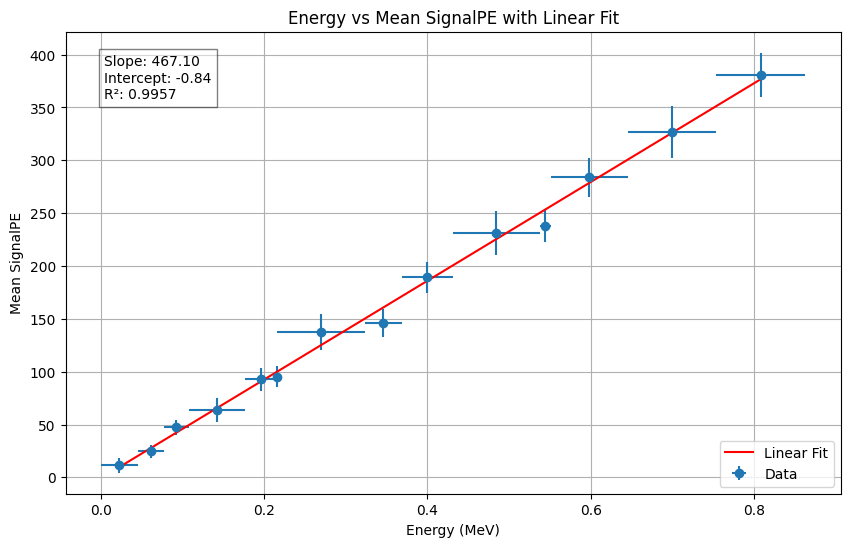

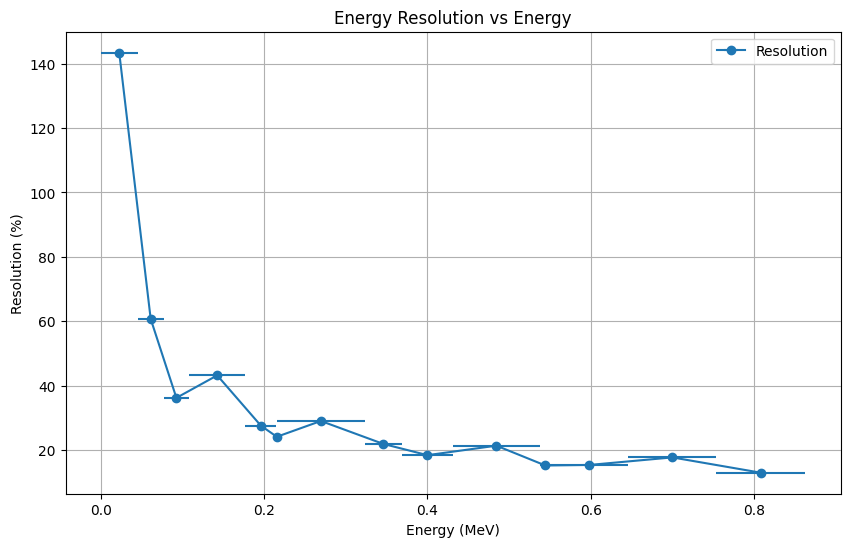

In [25]:
import uproot
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import linregress
from pathlib import Path

# Path to the combined ROOT file
file_path = 'combined.root'

# Open the ROOT file
root_file = uproot.open(file_path)

# Access the trees
edep_tree = root_file['EdepCounter']
sipm_tree = root_file['SiPM']

# Read the branches into pandas DataFrames
edep_df = edep_tree.arrays(['EventID', 'Edep_MeV'], library='pd')
sipm_df = sipm_tree.arrays(['EventID', '#PE', '#NoisePE'], library='pd')

# Merge the DataFrames on EventID
merged_df = pd.merge(edep_df, sipm_df, on='EventID')

# Compute SignalPE
merged_df['SignalPE'] = merged_df['#PE'] - merged_df['#NoisePE']

# Sort by Edep_MeV
merged_df = merged_df.sort_values('Edep_MeV')

# Define fine bin width (0.001 MeV)
bin_width = 0.001
min_edep = merged_df['Edep_MeV'].min()
max_edep = merged_df['Edep_MeV'].max()
bin_edges = np.arange(min_edep, max_edep + bin_width, bin_width)

# Assign fine bins
merged_df['fine_bin'] = pd.cut(merged_df['Edep_MeV'], bins=bin_edges, labels=False, include_lowest=True)

# Get counts per fine bin
bin_counts = merged_df['fine_bin'].value_counts().sort_index()

# Merge small bins
min_events = 10000
merged_groups = []
current_group = []
current_count = 0
group_id = 0

for bin_idx, count in bin_counts.items():
    current_group.append(bin_idx)
    current_count += count
    if current_count >= min_events:
        merged_df.loc[merged_df['fine_bin'].isin(current_group), 'merged_bin'] = group_id
        low_edge = bin_edges[min(current_group)]
        high_edge = bin_edges[max(current_group) + 1]
        merged_groups.append((group_id, low_edge, high_edge, current_count))
        group_id += 1
        current_group = []
        current_count = 0

# Handle remaining group
if current_group:
    if merged_groups:
        last_group_id, last_low, last_high, last_count = merged_groups[-1]
        merged_df.loc[merged_df['fine_bin'].isin(current_group), 'merged_bin'] = last_group_id
        new_high = bin_edges[max(current_group) + 1]
        merged_groups[-1] = (last_group_id, last_low, new_high, last_count + current_count)
    else:
        low_edge = bin_edges[min(current_group)]
        high_edge = bin_edges[max(current_group) + 1]
        merged_df.loc[merged_df['fine_bin'].isin(current_group), 'merged_bin'] = group_id
        merged_groups.append((group_id, low_edge, high_edge, current_count))

merged_df['merged_bin'] = merged_df['merged_bin'].astype(int)

# Group by merged_bin
grouped = merged_df.groupby('merged_bin')

# Collect data for plots
energies = []
xerrs = []
means = []
stds = []
resolutions = []

for bin_id, group in grouped:
    for g_id, low, high, cnt in merged_groups:
        if g_id == bin_id:
            # Midpoint and half-width
            mid_energy = (low + high) / 2
            half_width = (high - low) / 2
            mean_pe = group['SignalPE'].mean()
            std_pe = group['SignalPE'].std()
            res = (2.355 * std_pe / mean_pe * 100) if mean_pe != 0 else 0
            energies.append(mid_energy)
            xerrs.append(half_width)
            means.append(mean_pe)
            stds.append(std_pe)
            resolutions.append(res)
            break

# Plot 1: Energy vs Mean SignalPE with error bars and linear fit
plt.figure(figsize=(10, 6))
plt.errorbar(energies, means, yerr=stds, xerr=xerrs, fmt='o', label='Data')
slope, intercept, r_value, p_value, std_err = linregress(energies, means)
fit_line = slope * np.array(energies) + intercept
plt.plot(energies, fit_line, 'r-', label='Linear Fit')
text = f'Slope: {slope:.2f}\nIntercept: {intercept:.2f}\nR²: {r_value**2:.4f}'
plt.text(0.05, 0.95, text, transform=plt.gca().transAxes, verticalalignment='top', bbox=dict(facecolor='white', alpha=0.5))
plt.xlabel('Energy (MeV)')
plt.ylabel('Mean SignalPE')
plt.title('Energy vs Mean SignalPE with Linear Fit')
plt.legend()
plt.grid(True)
plt.savefig('energy_vs_mean_signalpe.png')
plt.show()

# Plot 2: Energy vs Resolution
plt.figure(figsize=(10, 6))
plt.errorbar(energies, resolutions, xerr=xerrs, fmt='o-', label='Resolution')
plt.xlabel('Energy (MeV)')
plt.ylabel('Resolution (%)')
plt.title('Energy Resolution vs Energy')
plt.legend()
plt.grid(True)
plt.savefig('energy_resolution.png')
plt.show()